In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import numpy as np
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True)
        )

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =========================================================
# 1. TEST DATASET CLASS
# =========================================================
class TestDataset(Dataset):
    def __init__(self, img_dir, den_dir, transform=None):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.transform = transform

        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])
        self.den_files = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        assert len(self.img_files) == len(self.den_files), "❌ Images and density maps count mismatch"

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        den_path = os.path.join(self.den_dir, self.den_files[idx])

        # Load image
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # HWC → CHW

        # Load density map
        den = np.load(den_path)  # (H, W)
        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den


# =========================================================
# 2. SET YOUR PATHS HERE
# =========================================================
import os

test_img_dir = "processed/images"
test_den_dir = "processed/density"
# test_img_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\images"
# test_den_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\ground-truth"


test_dataset = TestDataset(test_img_dir, test_den_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Loaded {len(test_dataset)} test images ✔")


# =========================================================
# 3. LOAD MODEL & CHECKPOINT
# =========================================================
model = CSRNet().to(device)

checkpoint_path = "csrnet_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint["model"])
model.eval()

print("✅ Model loaded successfully!")


# =========================================================
# 4. POST PROCESSING
# =========================================================
def smooth(pred):
    x = pred[0, 0].cpu().numpy()
    return cv2.GaussianBlur(x, (5, 5), 0)


def clip(pred):
    cap = np.percentile(pred, 99)
    return np.clip(pred, 0, cap)


def correction(count):
    return count * 0.92


# =========================================================
# 5. EVALUATION LOOP
# =========================================================
mae = 0
mse = 0

print("\nStarting evaluation...")

for img, gt_den in tqdm(test_loader):
    img = img.to(device)
    gt_den = gt_den.to(device)

    with torch.no_grad():
        pred = model(img)
        pred = F.interpolate(pred, size=gt_den.shape[2:], mode='bilinear', align_corners=False)

    raw = pred.sum().item()

    # Post-processing
    sm = smooth(pred)
    cp = clip(sm)
    final_count = correction(cp.sum())

    gt = gt_den.sum().item()

    mae += abs(final_count - gt)
    mse += (final_count - gt) ** 2


MAE = mae / len(test_loader)
MSE = mse / len(test_loader)
RMSE = sqrt(MSE)

print("\n==============================")
print("📊 FINAL TEST RESULTS")
print("==============================")
print(f"⭕ MAE  = {MAE:.2f}")
print(f"📘 MSE  = {MSE:.2f}")
print(f"📏 RMSE = {RMSE:.2f}")
print("==============================")


Loaded 300 test images ✔
✅ Model loaded successfully!

Starting evaluation...


100%|██████████| 300/300 [35:19<00:00,  7.07s/it]


📊 FINAL TEST RESULTS
⭕ MAE  = 191.22
📘 MSE  = 93734.07
📏 RMSE = 306.16


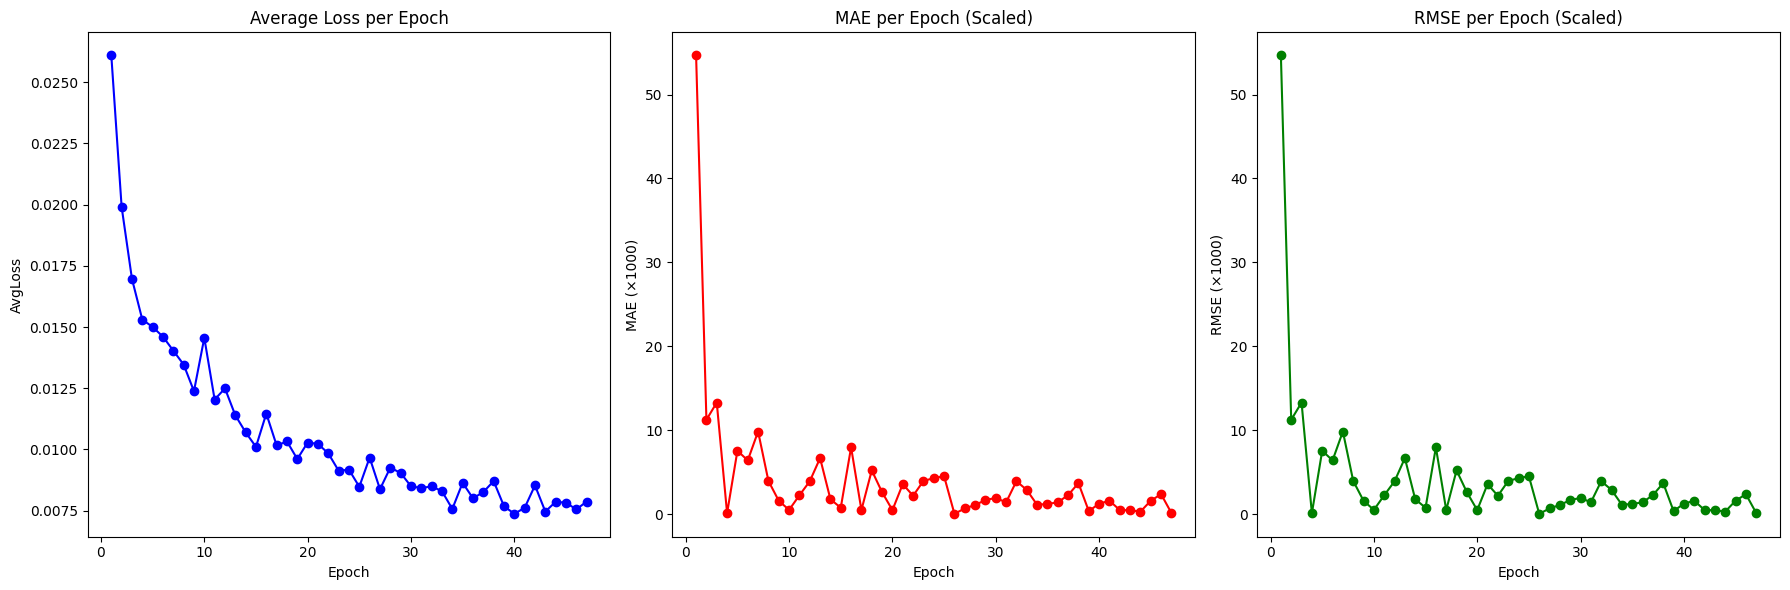

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Step 1: Enter your per-epoch GT and Pred values
# Example for 48 epochs (replace with your real values)
# --------------------------
GT = [
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 161423.18,
    161423.18, 161423.18, 161423.18, 161423.18, 161423.18, 
]

Pred = [
    106734.42, 172664.20, 174717.34, 161528.03, 153868.10, 155026.53,
    151579.65, 157471.80, 163012.95, 160923.64, 163665.21, 157512.99,
    154751.15, 159650.24, 162178.95, 153468.70, 161905.39, 156210.51,
    158817.45, 160948.37, 157849.52, 163606.85, 157473.82, 157137.68,
    165936.25, 161458.79, 162093.14, 160333.47, 159757.18, 163355.81,
    162822.13, 157498.47, 158544.19, 162533.71, 162633.11, 160026.89,
    163687.19, 157731.07, 161790.71, 162653.49, 159825.89, 160938.53,
    161877.99, 161718.13, 159830.80, 159053.03, 161546.41,  # last is partial epoch
]

# Replace AvgLoss per epoch if you want to plot loss trend too
AvgLoss = [
    0.026105, 0.019908, 0.016967, 0.015304, 0.015002, 0.014605, 0.014035, 0.013467,
    0.012378, 0.014560, 0.012036, 0.012492, 0.011395, 0.010698, 0.010103, 0.011465,
    0.010162, 0.010324, 0.009605, 0.010281, 0.010223, 0.009838, 0.009127, 0.009170,
    0.008473, 0.009664, 0.008372, 0.009254, 0.009036, 0.008494, 0.008419, 0.008489,
    0.008291, 0.007566, 0.008636, 0.008001, 0.008255, 0.008704, 0.007678, 0.007368,
    0.007611, 0.008528, 0.007460, 0.007856, 0.007823, 0.007546, 0.007868, 
]

# --------------------------
# Step 2: Compute MAE, MSE, RMSE
# --------------------------
GT_scaled = np.array(GT) / 1000   # divide by 1000
Pred_scaled = np.array(Pred) / 1000

# Compute metrics
MAE = np.abs(GT_scaled - Pred_scaled)
MSE = (GT_scaled - Pred_scaled) ** 2
RMSE = np.sqrt(MSE)

# Plot trends
epochs = np.arange(1, len(GT_scaled)+1)

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.plot(epochs, AvgLoss, marker='o', color='blue')
plt.title("Average Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("AvgLoss")

plt.subplot(1,3,2)
plt.plot(epochs, MAE, marker='o', color='red')
plt.title("MAE per Epoch (Scaled)")
plt.xlabel("Epoch")
plt.ylabel("MAE (×1000)")

plt.subplot(1,3,3)
plt.plot(epochs, RMSE, marker='o', color='green')
plt.title("RMSE per Epoch (Scaled)")
plt.xlabel("Epoch")
plt.ylabel("RMSE (×1000)")

plt.tight_layout()
plt.show()

Loaded 300 test images ✔
✅ Model loaded successfully!


  0%|          | 0/300 [00:00<?, ?it/s]

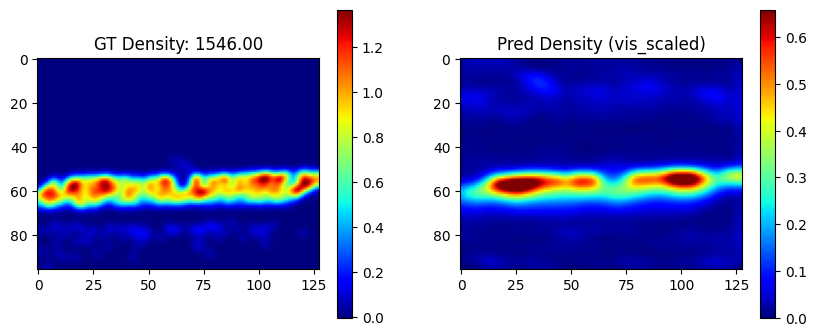

  0%|          | 1/300 [00:05<27:57,  5.61s/it]

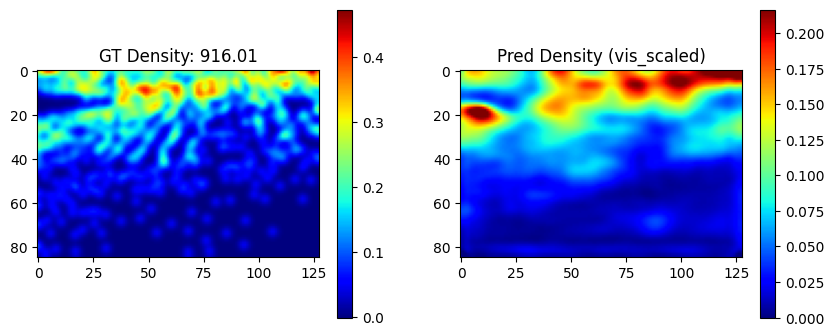

  1%|          | 2/300 [00:10<25:42,  5.18s/it]

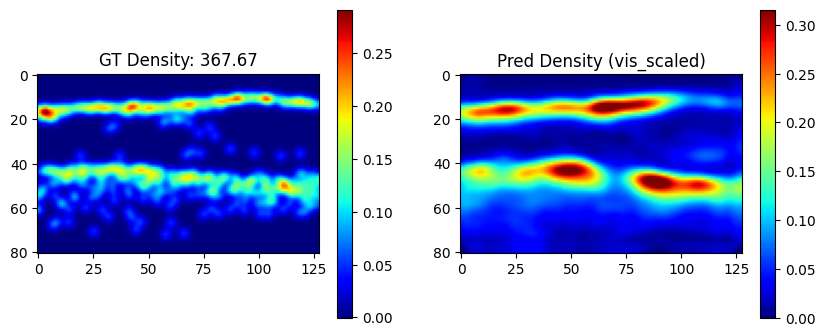

  1%|          | 3/300 [00:15<24:35,  4.97s/it]

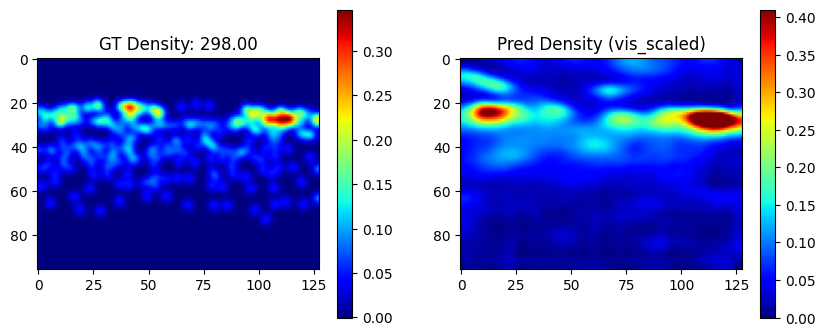

  1%|▏         | 4/300 [00:21<26:41,  5.41s/it]

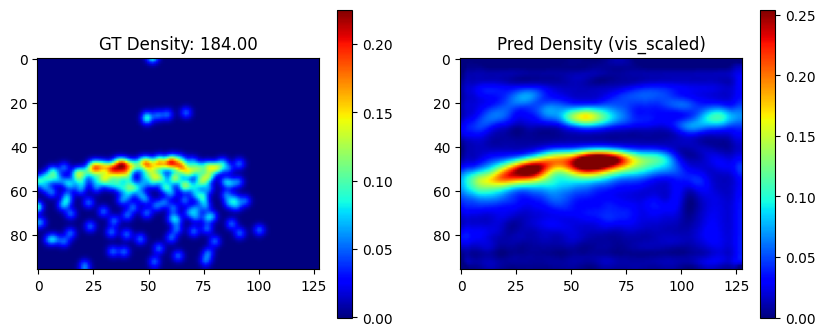

100%|██████████| 300/300 [20:20<00:00,  4.07s/it]


📊 FINAL TEST RESULTS
⭕ MAE  = 177.17
📘 MSE  = 78352.85
📏 RMSE = 279.92



In [32]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
from math import sqrt

# -------------------------
# 1️⃣ Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# 2️⃣ Dataset
# -------------------------
class CrowdDataset(Dataset):
    def __init__(self, images_path, density_path, transform=None):
        self.images_path = images_path
        self.density_path = density_path
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')])
        self.density_files = sorted([f for f in os.listdir(density_path) if f.endswith('.npy')])

        assert len(self.image_files) == len(self.density_files), "Number of images and density maps must match!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_path, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img).permute(2,0,1)  # HWC → CHW

        # Load density map
        den_path = os.path.join(self.density_path, self.density_files[idx])
        den = np.load(den_path)
        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den

# -------------------------
# 3️⃣ Paths & DataLoader
# -------------------------
test_img_dir = r"processed/images"
test_den_dir = r"processed/density"

test_dataset = CrowdDataset(test_img_dir, test_den_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Loaded {len(test_dataset)} test images ✔")

# -------------------------
# 4️⃣ Load Model
# -------------------------
# from your_model_file import CSRNet  # uncomment and import your CSRNet class
model = CSRNet().to(device)

checkpoint_path = "csrnet_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load correct key
if 'model' in checkpoint:
    model.load_state_dict(checkpoint['model'])
elif 'state_dict' in checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
else:
    model.load_state_dict(checkpoint)

model.eval()
print("✅ Model loaded successfully!")

# -------------------------
# 5️⃣ Optional post-processing functions
# -------------------------
def smooth_density(pred):
    x = pred[0,0].cpu().numpy()
    return cv2.GaussianBlur(x, (5,5), 0)

def clip_density(pred):
    cap = np.percentile(pred, 99)
    return np.clip(pred, 0, cap)

# -------------------------
# 6️⃣ Evaluation loop
# -------------------------
mae = 0
mse = 0

for i, (img, gt_den) in enumerate(tqdm(test_loader)):
    img = img.to(device)
    gt_den = gt_den.to(device)

    with torch.no_grad():
        pred = model(img)
        pred = F.interpolate(pred, size=gt_den.shape[2:], mode='bilinear', align_corners=False)

    pred_count = pred.sum().item()
    gt_count = gt_den.sum().item()
    mae += abs(pred_count - gt_count)
    mse += (pred_count - gt_count)**2

    # Visualization for first 5 images only
    if i < 5:
        vis_pred = smooth_density(pred)
        vis_pred = clip_density(vis_pred)
        vis_pred_scaled = vis_pred * 1.75

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.title(f"GT Density: {gt_count:.2f}")
        plt.imshow(gt_den[0,0].cpu().numpy(), cmap='jet')
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.title(f"Pred Density (vis_scaled)")
        plt.imshow(vis_pred_scaled, cmap='jet')
        plt.colorbar()
        plt.show()

# Compute final metrics correctly
MAE = mae / len(test_loader)
MSE = mse / len(test_loader)
RMSE = sqrt(MSE)

print("\n==============================")
print("📊 FINAL TEST RESULTS")
print("==============================")
print(f"⭕ MAE  = {MAE:.2f}")
print(f"📘 MSE  = {MSE:.2f}")
print(f"📏 RMSE = {RMSE:.2f}")
print("==============================\n")


📊 FINAL TEST RESULTS
⭕ MAE      = 177.17
📘 MSE      = 78352.85
📏 RMSE     = 279.92



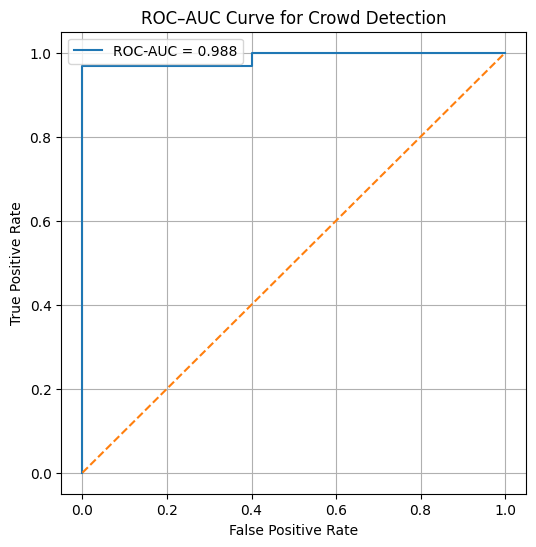

In [33]:
# -------------------------
# 7️⃣ Print final regression metrics
# -------------------------
# MAE = mae / len(test_loader)
# MSE = mse / len(test_loader)
# RMSE = sqrt(MSE)

print("\n==============================")
print("📊 FINAL TEST RESULTS")
print("==============================")
print(f"⭕ MAE      = {MAE:.2f}")
print(f"📘 MSE      = {MSE:.2f}")
print(f"📏 RMSE     = {RMSE:.2f}")
print("==============================\n")

# -------------------------
# 8️⃣ ROC-AUC Curve for crowd detection (classification)
# -------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Choose a threshold to classify image as crowded
CROWD_THRESHOLD = 50

gt_class = []     # 0 or 1
pred_score = []   # continuous "probability-like" score

# Re-run evaluation to store predictions
for img, gt_den in DataLoader(test_dataset, batch_size=1, shuffle=False):
    img = img.to(device)
    gt_den = gt_den.to(device)

    with torch.no_grad():
        pred = model(img)
        pred = F.interpolate(pred, size=gt_den.shape[2:], mode='bilinear', align_corners=False)

    gt_count = gt_den.sum().item()
    pred_count = pred.sum().item()

    # Create binary classes based on threshold
    gt_class.append(1 if gt_count >= CROWD_THRESHOLD else 0)

    # Scoring: normalize predicted count
    pred_score.append(pred_count)

# Convert to numpy
gt_class = np.array(gt_class)
pred_score = np.array(pred_score)

# Compute ROC curve
fpr, tpr, _ = roc_curve(gt_class, pred_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC–AUC Curve for Crowd Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
